# Project 5: Malicious Urls
## Aidan Jimenez & Russell Smith
### 4/27/25

### Description
The notebook goes through a dataset of malicous urls and aims to analyze them by breaking out aspects of each of the links into a number value that can help make a distinct difference between each of the classification types of urls. There is also a section that uses a subset of the urls to try and analyze them with whois data.

### Self-Evaluation
Based off of what we completed with reference to the proposal document we got to the A level if not stretch. After testing of the learning models a neural net was not the most effective with this data so we had to change our path with the project and use gradient boosting as our main model. Due to the amount of time it took to get the whois information we aimed to make a proof of concept on how this project could develop with more information. Also the organization of visuals and markdown meet the need of an A level. 

## Imports and Data Loading
This section is just the imports that are used and loading the csv with 600,000 urls.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from urllib.request import urlopen
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Read in the data

In [2]:
df = pd.read_csv("malicious_phish.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


## Exploratory Data Analysis

Text(0.5, 1.0, 'Urls by Type')

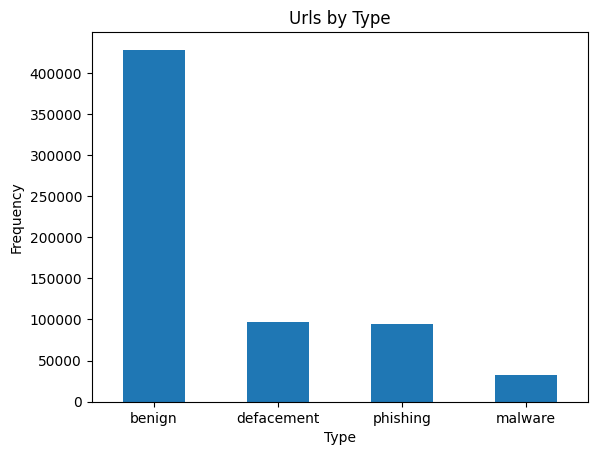

In [4]:
df['type'].value_counts().plot(kind="bar")
plt.xlabel("Type")
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.title("Urls by Type")

In [5]:
df['length'] = df['url'].apply(lambda x: len(x))
df

,url,type,length
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45


A majority of our urls are beningn which is a non malicious link. It might cause issues in the future when trying to accurately detect what may be a malicous link. For the case of this model we may put all the malicous links together to make a more generic url detection system since it is more important to detect whether it is malicious or not as compared to which type of malicous activity it could be.

In [6]:
#Count the number of each possible attributes that can be in a url
attribute = ['@','?','-','=','.','#','%','+','$','!','*',',','//', '(', ')']
for symbol in attribute:
    df[symbol] = df['url'].apply(lambda x: x.count(symbol))
df

,url,type,length,@,?,-,=,.,#,%,+,$,!,*,",",//,(,)
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45,0,0,0,0,2,0,0,0,0,0,0,0,0,1,1


The one attribute that was interesting and messed with the accuracy of the model prediction was the number of slashes. Originally we tried a single slash and then a double slash causing the accuracy to drastically increase.

In [7]:
df['type'].unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

Text(0.5, 1.0, 'Slashes v Url Type')

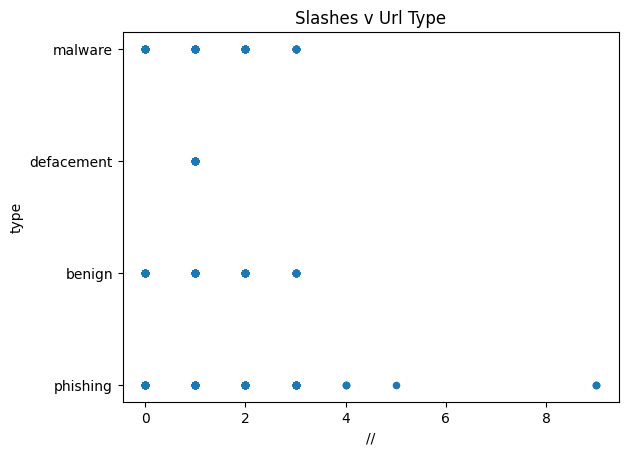

In [8]:
df.plot(x='//', y='type', kind="scatter")
plt.title("Slashes v Url Type")

Based on this scatter plot it seems that both malware and defacement tend to have a range of slashes that they tend to fall in while benign and defacement have a more similar range of slashes.

Text(0.5, 1.0, 'Dots v Url Type')

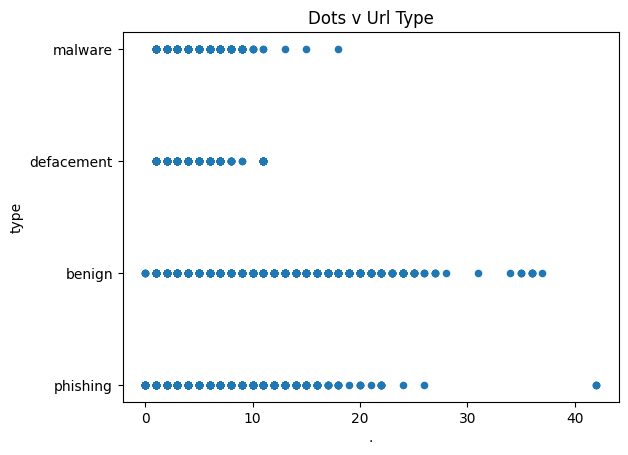

In [9]:
df.plot(x='.', y='type', kind="scatter")
plt.title("Dots v Url Type")

The number of dots in the urls also seem to resemble the same pattern where the malware and the defacement have their own distrobution of dots while benign and phising is under a similar range

In [10]:
# Determine if the url is being used by a url shortening service
def detectShortened(original_url):
  url_shorteners = [
    "bit.ly",
    "tinyurl.com",
    "ow.ly",
    "is.gd",
    "v.gd",
    "soo.gd",
    "t.co",
    "lnkd.in",
    "buff.ly",
    "adf.ly",
    "shorte.st",
    "go.gl",
    "y2u.be",
    "youtu.be",
    "goo.gl",
    "po.st",
    "qr.cr",
    "snip.ly",
    "rebrand.ly",
    "bl.ink",
    "kutt.it",
    "cutt.ly",
    "shorturl.at",
    "tiny.cc",
    "osf.io",
    "doi.org",
    "arxiv.org",
    "git.io",
    "tny.im",
    "ulvis.net",
    "yourls.org",
    "polr.me",
    "branch.io",
    "app.goo.gl",
    "bnc.lt",
    "bitly.is",
    "j.mp",
    "on.mash.to",
    "flip.it",
    "instagr.am",
    "pin.it",
    "medium.com",
    "at.at",
    "su.pr",
    "twitpic.com",
    "flic.kr",
    "posterous.com",
    "digg.com",
    "plurk.com",
    "yep.it",
    "zi.pe",
    "linktr.ee",
    "taplink.cc",
    "bio.link",
    "solo.to",
    "beacons.ai",
    "luma.events",
    "eventbrite.com",
    "bento.me",
    "start.me",
    "about.me",
    "carrd.co",
    "milkshake.app",
    "paged.co",
    "shortstack.com",
    "woobox.com",
    "easypromosapp.com",
    "wishpond.com",
    "vyper.io",
    "kickofflabs.com",
    "leadpages.net",
    "instapage.com",
    "unbounce.com",
    "shortsw.com"
  ]

  for url in url_shorteners:
    if url in original_url:
      return 1
    else:
      return 0


df['redirect'] = df['url'].apply(detectShortened)

Text(0, 0.5, 'Frequency')

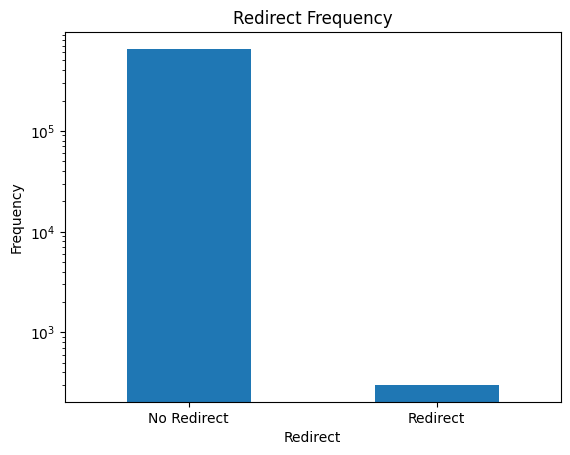

In [11]:
df['redirect'].value_counts().plot(kind="bar", logy=True)
plt.title("Redirect Frequency")
plt.xlabel('Redirect')
plt.xticks([0,1],['No Redirect', 'Redirect'], rotation=0)
plt.ylabel("Frequency")

Based on this graph most of these links are not redirects. Though that is the case this information may be helpful to the models in the future.

Password Entropy Calculator
https://github.com/error-27/Entropy-Calculator/blob/main/Entropy.py

The reason for trying to calculate the "password" entropy of these links is to see how difficult the link would be to guess. This is under the assumption that most links that are real are going to be by companies which will have common words as their links instead of a jumbled mess of characters. One issue where this algorithm will not work well is that in a Url there are no capital letters so this will not work entirely how its supposed to but can still potenially give a value that can be telling.

In [12]:
import math
#!pip install tldextract
# Needed to use tld extract becuase
#urllib parse was not able to get all links properly
import tldextract


def calculate(length, char_amount):
    if char_amount > 0:
      return math.log2(char_amount) * length
    else:
      return 0


def find_chars(password):
    char_amount = 0
    char_sets = [False, False, False, False]
    char_nums = [26, 26, 10, 32]
    for i in password:
        if i.islower():
            char_sets[0] = True
        if i.isupper():
            char_sets[1] = True
        if i.isdigit():
            char_sets[2] = True
        if not i.isalnum() and i.isascii():
            char_sets[3] = True

    for x in range(4):
        if char_sets[x]:
            char_amount += char_nums[x]

    return len(password), char_amount

def calcEntropy(password):
  domain = tldextract.extract(password).domain
  length, amount = find_chars(domain)
  entropy  = calculate(length, amount)
  return entropy

df['domain_entropy'] = df['url'].apply(calcEntropy)
df

,url,type,length,@,?,-,=,.,#,%,+,$,!,*,",",//,(,),redirect,domain_entropy
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,52.721829
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,36.189475
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,47.004397
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,1,4,3,0,0,0,0,0,0,0,1,0,0,0,82.011734
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,1,3,2,0,0,0,0,0,0,0,1,0,0,0,111.301639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,14.101319
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,37.603518
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,37.603518
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45,0,0,0,0,2,0,0,0,0,0,0,0,0,1,1,0,42.303957


<Axes: xlabel='domain_entropy', ylabel='type'>

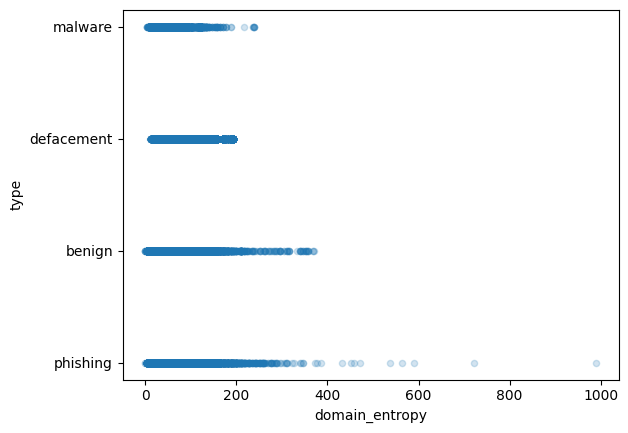

In [13]:
df.plot(x='domain_entropy', y='type', kind='scatter', alpha=0.2)

Each of the classifications have seemed to lay in certain ranges that can make them more distict. Based on this graph I could see this being a factor that could help narrow the range as to which classification this would be.

In [14]:
# Determine whether the url has https or not
def isHTTPS(url):
  if "https://" in url:
    return 1
  else:
    return 0

df["https"] = df['url'].apply(isHTTPS)

Text(0, 0.5, 'Frequency')

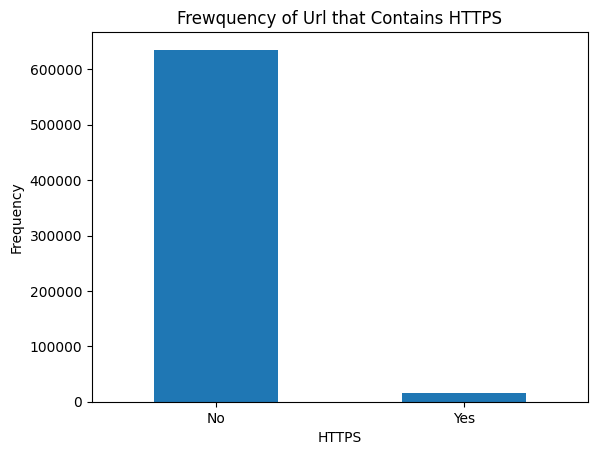

In [15]:
df['https'].value_counts().plot(kind='bar')
plt.title("Frewquency of Url that Contains HTTPS")
plt.xticks([0,1],['No', 'Yes'], rotation=0)
plt.xlabel("HTTPS")
plt.ylabel("Frequency")

The distinction of whether the link is https could be an indicator of how legitimate the url is. In HTTPS will usually mean that traffic is encrypted and is more secure which is built of the http method.

Text(0.5, 1.0, 'Correlation Between Attributes')

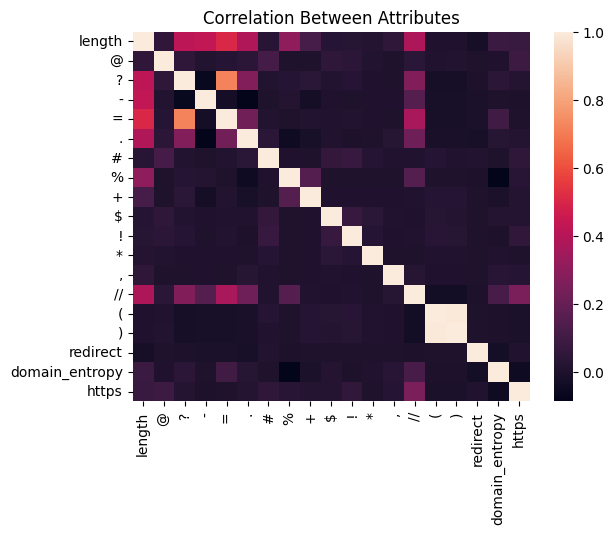

In [16]:
corr = df.drop(['url', 'type'], axis=1).corr()
sns.heatmap(corr )
plt.title("Correlation Between Attributes")

An interesting piece of information is when there is `//` in correlation with `=` which would mean that there is a query in the link. It is unclear as to what that could mean but it does not seem like something that should be more common than other attributes in the the urls. As for other attributes such as `?` and `=` they are directly linked to one another since this is the way to make a query in a url.

## Prepare Data for Model

In [17]:
ord_map= {
    'malware' : 0,
    'benign': 1,
    'phishing': 2,
    'defacement': 3,
}
X = df.drop(['url', 'type'], axis=1)
y = df['type'].map(ord_map)

Split the data in to train and test

In [18]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=0)

## MLP Classifier

Normalize the data

In [19]:
model = MLPClassifier(hidden_layer_sizes=(4, 16, 4),
                      solver='adam',
                      learning_rate_init=0.001,
                      activation='relu',
                      batch_size=64,
                      max_iter=500,
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True)

model.fit(Xtrain, ytrain)

Iteration 1, loss = 0.70588049
Validation score: 0.801627
Iteration 2, loss = 0.49038800
Validation score: 0.813798
Iteration 3, loss = 0.45589733
Validation score: 0.818382
Iteration 4, loss = 0.44762357
Validation score: 0.825372
Iteration 5, loss = 0.44200146
Validation score: 0.829727
Iteration 6, loss = 0.43811547
Validation score: 0.826152
Iteration 7, loss = 0.43574895
Validation score: 0.828971
Iteration 8, loss = 0.43283306
Validation score: 0.828077
Iteration 9, loss = 0.42967510
Validation score: 0.831148
Iteration 10, loss = 0.42649178
Validation score: 0.829017
Iteration 11, loss = 0.42307832
Validation score: 0.833784
Iteration 12, loss = 0.41981360
Validation score: 0.829406
Iteration 13, loss = 0.41795780
Validation score: 0.830461
Iteration 14, loss = 0.41637112
Validation score: 0.841004
Iteration 15, loss = 0.41541540
Validation score: 0.844763
Iteration 16, loss = 0.41197213
Validation score: 0.842196
Iteration 17, loss = 0.40851339
Validation score: 0.846367
Iterat

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=(4, 16, 4),
              max_iter=500, verbose=True)

In [20]:
for i, layer in enumerate(model.coefs_):
  print('Layer', i, 'has', layer.shape[0], 'nodes, each with', layer.shape[1], 'weight(s)')

Layer 0 has 19 nodes, each with 4 weight(s)
Layer 1 has 4 nodes, each with 16 weight(s)
Layer 2 has 16 nodes, each with 4 weight(s)
Layer 3 has 4 nodes, each with 4 weight(s)


In [21]:
model.best_validation_score_

0.849988539995416

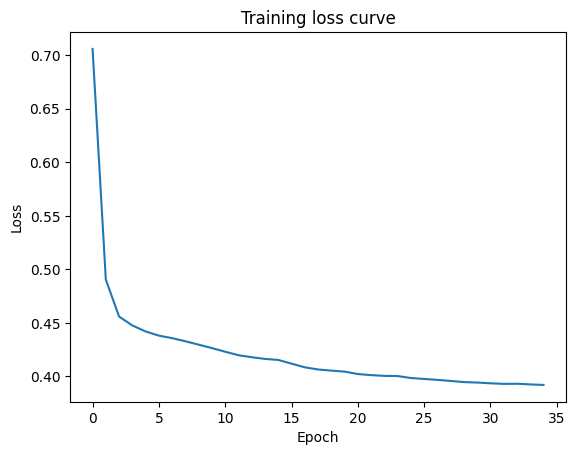

In [22]:
plt.plot(model.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training loss curve')
plt.show()

In [23]:
ypred = model.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.74      0.67      0.71     10669
           1       0.89      0.96      0.92    141674
           2       0.66      0.32      0.43     31027
           3       0.80      0.95      0.87     31524

    accuracy                           0.85    214894
   macro avg       0.77      0.72      0.73    214894
weighted avg       0.83      0.85      0.83    214894



## Random Forest Classifier

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      6534
           1       0.83      0.99      0.91     85491
           2       0.85      0.05      0.10     18852
           3       0.76      0.92      0.83     19362

    accuracy                           0.82    130239
   macro avg       0.85      0.63      0.64    130239
weighted avg       0.83      0.82      0.77    130239



## Grid Search

In [25]:
from sklearn.model_selection import GridSearchCV

# Which hyperparameters do we want to try?
param_grid = {'n_estimators': np.arange(30, 34, 2),
              'max_depth': np.arange(12, 18, 3),
              'learning_rate': np.arange(0.07, 0.14, 0.01)}

# We can incorporate cross-validation into the grid search
# by specifying cv=5.
grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, verbose=1)

# We'll use just the training data, so that we can evaluate the best
# model against data that was unseen during training.
grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': array([0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14]),
                         'max_depth': array([12, 15]),
                         'n_estimators': array([30, 32])},
             verbose=1)

In [26]:
print(grid.best_params_)

# and the best accuracy
print(grid.best_score_)

# then we can train the final model with the best hyperparameters
# model = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=0.1)
# model.fit(Xtrain, ytrain)

# predict the test data to see how well the model generalizes
ypred = model.predict(Xtest)
accuracy = accuracy_score(ytest, ypred)
print(accuracy)

{'learning_rate': np.float64(0.13999999999999996), 'max_depth': np.int64(15), 'n_estimators': np.int64(32)}
0.9085072749286895
0.8503355142535389


## PCA

original shape:    (651191, 19)
transformed shape: (651191, 2)


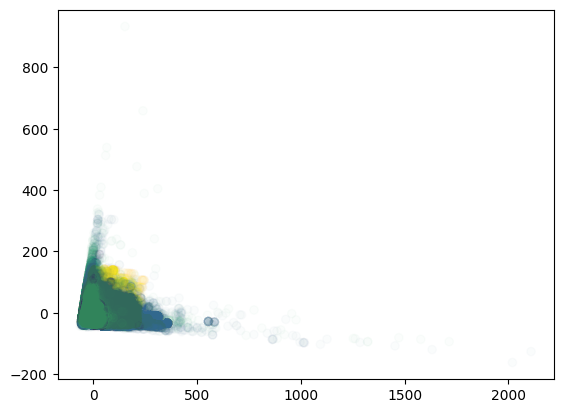

In [27]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)


fig, ax = plt.subplots()

# note that transformed data becomes a numpy array
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.02)

## Gradient Boosting

In [28]:

model = XGBClassifier(n_estimators=1, max_depth=300, learning_rate=0.001)

model.fit(Xtrain, ytrain)

# make predictions for test data
ypred = model.predict(Xtest)

# evaluate predictions
accuracy = accuracy_score(ytest, ypred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 90.48%


Text(0.5, 1.0, 'Feature Importance in Malicious Urls')

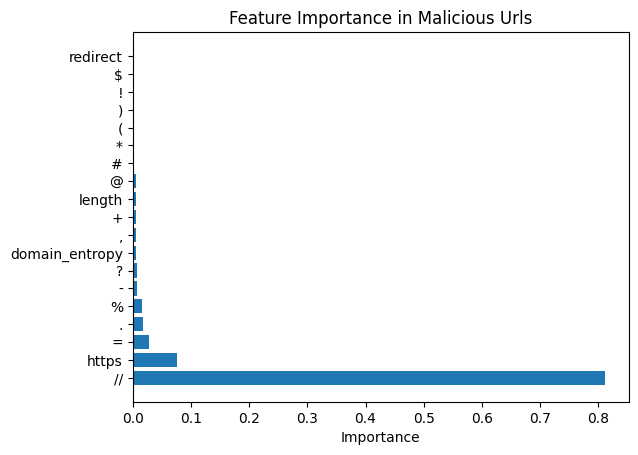

In [29]:
# Feature Importance

# Make a DataFrame for ease of sorting and visualization
feat_imp = pd.DataFrame({'Feature': X.columns,
                      'Importance': model.feature_importances_})

feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots()

# horizontal bar charts can make text easier to read
ax.barh(feat_imp['Feature'], feat_imp['Importance'])
ax.set_xlabel('Importance')
ax.set_title('Feature Importance in Malicious Urls')


# Prediction Matrix

[[  9310    233    579    547]
 [    71 136463   4810    330]
 [   246  10439  18292   2050]
 [   159    326    678  30361]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     10669
           1       0.93      0.96      0.94    141674
           2       0.75      0.59      0.66     31027
           3       0.91      0.96      0.94     31524

    accuracy                           0.90    214894
   macro avg       0.88      0.85      0.86    214894
weighted avg       0.90      0.90      0.90    214894



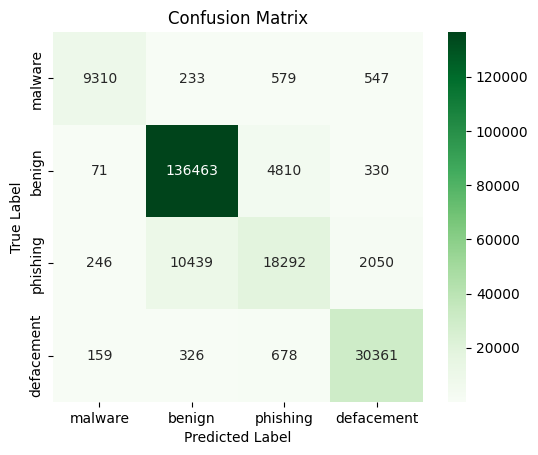

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))
label_map = {
    0: 'malware',
    1: 'benign',
    2: 'phishing',
    3: 'defacement',
}
labels = [0,1,2,3]
cm = confusion_matrix(ytest, ypred, labels=labels)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                    cmap="Greens",
                    xticklabels=list(label_map.values()),
                    yticklabels=list(label_map.values()))

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix is based off of the Gradient Boosting Model, as we saw in the initial graph that most of the predicted urls were benign. Though the overall model is not entirely bad as it was able to have a good amount of urls that were properly predicted. The type of url that had the lowest recall is the the phishing urls which was incorrectly predicted as a benign url. In this case that would make sense since these phishing links are aimed at copying the benign ones. 

# Whois Data
The data was collected using the whois package in python to extract the whois information for each url. The only urls that work were the ones that ended with `.com`, `.edu`, `.org`, and `.net`. In the case of our data set not all of them have just `.com` and consist of something like `.com.uk` which are region based tld's. Due to some of these links having odd tld's we are not able to get whois information for every link that is in the first ten thousand links so there will be some loss. 

In [31]:
wdf = pd.read_csv("malicious_phish_10k_whoisinfo.csv")
wdf.head()

,url,type,creation_date,updated_date,expiration_date,domain_name,registrar_url
0,br-icloud.com.br,phishing,2024-01-10 00:00:00,2024-12-19 00:00:00,2026-01-10 00:00:00,br-icloud.com.br,NaN
1,mp3raid.com/music/krizz_kaliko.html,benign,2000-02-14 03:25:53,2024-02-14 10:39:41,2026-02-14 03:25:53,MP3RAID.COM,"['http://www.godaddy.com', 'https://www.godadd..."
2,bopsecrets.org/rexroth/cr/1.htm,benign,2000-01-25 22:48:55,2024-12-01 07:52:25,2028-01-25 22:48:55,bopsecrets.org,http://www.networksolutions.com
3,http://www.garage-pirenne.be/index.php?option=...,defacement,2025-04-12 00:00:00,NaN,NaN,garage-pirenne.be,NaN
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2024-12-01 17:37:48,2024-12-01 17:43:54,2025-12-01 17:37:48,ADVENTURE-NICARAGUA.NET,http://www.above.com


In [32]:
wdf.drop(columns=['domain_name'])

,url,type,creation_date,updated_date,expiration_date,registrar_url
0,br-icloud.com.br,phishing,2024-01-10 00:00:00,2024-12-19 00:00:00,2026-01-10 00:00:00,NaN
1,mp3raid.com/music/krizz_kaliko.html,benign,2000-02-14 03:25:53,2024-02-14 10:39:41,2026-02-14 03:25:53,"['http://www.godaddy.com', 'https://www.godadd..."
2,bopsecrets.org/rexroth/cr/1.htm,benign,2000-01-25 22:48:55,2024-12-01 07:52:25,2028-01-25 22:48:55,http://www.networksolutions.com
3,http://www.garage-pirenne.be/index.php?option=...,defacement,2025-04-12 00:00:00,NaN,NaN,NaN
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2024-12-01 17:37:48,2024-12-01 17:43:54,2025-12-01 17:37:48,http://www.above.com
...,...,...,...,...,...,...
9995,movies.tvguide.com/eastern-promises/285629,benign,1994-12-06 05:00:00,2024-03-15 14:49:36,2026-12-05 05:00:00,http://www.tucows.com
9996,http://themeforest.net/item/moksha-one-multi-p...,benign,2007-11-27 03:49:29,2023-10-26 09:43:29,2025-11-27 03:49:29,http://www.markmonitor.com
9997,flaggedrevs.labs.wikimedia.org/wiki/New_York_S...,benign,2003-03-16 08:22:47,2025-02-17 09:23:41,2026-03-16 08:22:47,http://www.markmonitor.com
9998,thetakeaway.org/people/victor-begg/,benign,2008-01-26 03:23:04,2024-12-27 22:29:33,2026-01-26 03:23:04,"['http://registrar.amazon.com', 'https://regis..."


### Drop all rows where no whois data was returned

In [33]:
mask = wdf['domain_name'].isna()

wdf = wdf[~mask]
wdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8459 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              8459 non-null   object
 1   type             8459 non-null   object
 2   creation_date    8099 non-null   object
 3   updated_date     8041 non-null   object
 4   expiration_date  7977 non-null   object
 5   domain_name      8459 non-null   object
 6   registrar_url    7357 non-null   object
dtypes: object(7)
memory usage: 528.7+ KB


Text(0, 0.5, 'Frequency')

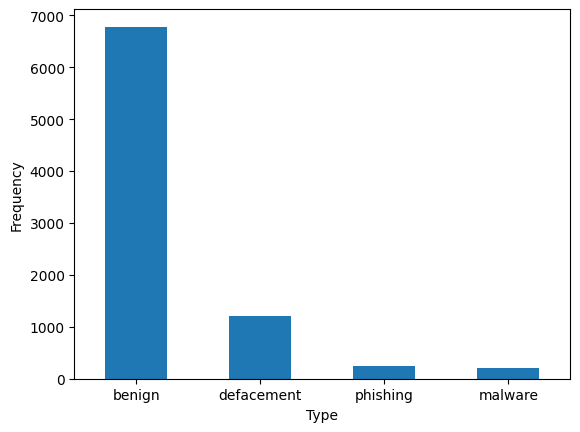

In [34]:
wdf['type'].value_counts().plot(kind="bar")
plt.xlabel("Type")
plt.xticks(rotation=0)
plt.ylabel("Frequency")

### Feature Extraction

In [35]:
wdf['registrar_url'] = wdf['registrar_url'].fillna("")

wdf.info()
    


<class 'pandas.core.frame.DataFrame'>
Index: 8459 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              8459 non-null   object
 1   type             8459 non-null   object
 2   creation_date    8099 non-null   object
 3   updated_date     8041 non-null   object
 4   expiration_date  7977 non-null   object
 5   domain_name      8459 non-null   object
 6   registrar_url    8459 non-null   object
dtypes: object(7)
memory usage: 528.7+ KB


In [36]:
wdf

,url,type,creation_date,updated_date,expiration_date,domain_name,registrar_url
0,br-icloud.com.br,phishing,2024-01-10 00:00:00,2024-12-19 00:00:00,2026-01-10 00:00:00,br-icloud.com.br,
1,mp3raid.com/music/krizz_kaliko.html,benign,2000-02-14 03:25:53,2024-02-14 10:39:41,2026-02-14 03:25:53,MP3RAID.COM,"['http://www.godaddy.com', 'https://www.godadd..."
2,bopsecrets.org/rexroth/cr/1.htm,benign,2000-01-25 22:48:55,2024-12-01 07:52:25,2028-01-25 22:48:55,bopsecrets.org,http://www.networksolutions.com
3,http://www.garage-pirenne.be/index.php?option=...,defacement,2025-04-12 00:00:00,NaN,NaN,garage-pirenne.be,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2024-12-01 17:37:48,2024-12-01 17:43:54,2025-12-01 17:37:48,ADVENTURE-NICARAGUA.NET,http://www.above.com
...,...,...,...,...,...,...,...
9995,movies.tvguide.com/eastern-promises/285629,benign,1994-12-06 05:00:00,2024-03-15 14:49:36,2026-12-05 05:00:00,TVGUIDE.COM,http://www.tucows.com
9996,http://themeforest.net/item/moksha-one-multi-p...,benign,2007-11-27 03:49:29,2023-10-26 09:43:29,2025-11-27 03:49:29,THEMEFOREST.NET,http://www.markmonitor.com
9997,flaggedrevs.labs.wikimedia.org/wiki/New_York_S...,benign,2003-03-16 08:22:47,2025-02-17 09:23:41,2026-03-16 08:22:47,wikimedia.org,http://www.markmonitor.com
9998,thetakeaway.org/people/victor-begg/,benign,2008-01-26 03:23:04,2024-12-27 22:29:33,2026-01-26 03:23:04,thetakeaway.org,"['http://registrar.amazon.com', 'https://regis..."


In [37]:
wdf['length'] = wdf['url'].apply(lambda x: len(x))

wdf['r_length'] = wdf['registrar_url'].apply(lambda x: len(x))

wdf

,url,type,creation_date,updated_date,expiration_date,domain_name,registrar_url,length,r_length
0,br-icloud.com.br,phishing,2024-01-10 00:00:00,2024-12-19 00:00:00,2026-01-10 00:00:00,br-icloud.com.br,,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,2000-02-14 03:25:53,2024-02-14 10:39:41,2026-02-14 03:25:53,MP3RAID.COM,"['http://www.godaddy.com', 'https://www.godadd...",35,53
2,bopsecrets.org/rexroth/cr/1.htm,benign,2000-01-25 22:48:55,2024-12-01 07:52:25,2028-01-25 22:48:55,bopsecrets.org,http://www.networksolutions.com,31,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,2025-04-12 00:00:00,NaN,NaN,garage-pirenne.be,,88,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2024-12-01 17:37:48,2024-12-01 17:43:54,2025-12-01 17:37:48,ADVENTURE-NICARAGUA.NET,http://www.above.com,235,20
...,...,...,...,...,...,...,...,...,...
9995,movies.tvguide.com/eastern-promises/285629,benign,1994-12-06 05:00:00,2024-03-15 14:49:36,2026-12-05 05:00:00,TVGUIDE.COM,http://www.tucows.com,42,21
9996,http://themeforest.net/item/moksha-one-multi-p...,benign,2007-11-27 03:49:29,2023-10-26 09:43:29,2025-11-27 03:49:29,THEMEFOREST.NET,http://www.markmonitor.com,101,26
9997,flaggedrevs.labs.wikimedia.org/wiki/New_York_S...,benign,2003-03-16 08:22:47,2025-02-17 09:23:41,2026-03-16 08:22:47,wikimedia.org,http://www.markmonitor.com,59,26
9998,thetakeaway.org/people/victor-begg/,benign,2008-01-26 03:23:04,2024-12-27 22:29:33,2026-01-26 03:23:04,thetakeaway.org,"['http://registrar.amazon.com', 'https://regis...",35,63


In [38]:
attribute = ['@','?','-','=','.','#','%','+','$','!','*',',','//', '(', ')']
for symbol in attribute:
    wdf[symbol] = wdf['url'].apply(lambda x: x.count(symbol))

for symbol in attribute:
    wdf['r_' + symbol] = wdf['registrar_url'].apply(lambda x: x.count(symbol))

wdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8459 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              8459 non-null   object
 1   type             8459 non-null   object
 2   creation_date    8099 non-null   object
 3   updated_date     8041 non-null   object
 4   expiration_date  7977 non-null   object
 5   domain_name      8459 non-null   object
 6   registrar_url    8459 non-null   object
 7   length           8459 non-null   int64 
 8   r_length         8459 non-null   int64 
 9   @                8459 non-null   int64 
 10  ?                8459 non-null   int64 
 11  -                8459 non-null   int64 
 12  =                8459 non-null   int64 
 13  .                8459 non-null   int64 
 14  #                8459 non-null   int64 
 15  %                8459 non-null   int64 
 16  +                8459 non-null   int64 
 17  $                8459 non-null   int64

In [39]:
# Determine if the url is being used by a url shortening service
def detectShortened(original_url):
  url_shorteners = [
    "bit.ly",
    "tinyurl.com",
    "ow.ly",
    "is.gd",
    "v.gd",
    "soo.gd",
    "t.co",
    "lnkd.in",
    "buff.ly",
    "adf.ly",
    "shorte.st",
    "go.gl",
    "y2u.be",
    "youtu.be",
    "goo.gl",
    "po.st",
    "qr.cr",
    "snip.ly",
    "rebrand.ly",
    "bl.ink",
    "kutt.it",
    "cutt.ly",
    "shorturl.at",
    "tiny.cc",
    "osf.io",
    "doi.org",
    "arxiv.org",
    "git.io",
    "tny.im",
    "ulvis.net",
    "yourls.org",
    "polr.me",
    "branch.io",
    "app.goo.gl",
    "bnc.lt",
    "bitly.is",
    "j.mp",
    "on.mash.to",
    "flip.it",
    "instagr.am",
    "pin.it",
    "medium.com",
    "at.at",
    "su.pr",
    "twitpic.com",
    "flic.kr",
    "posterous.com",
    "digg.com",
    "plurk.com",
    "yep.it",
    "zi.pe",
    "linktr.ee",
    "taplink.cc",
    "bio.link",
    "solo.to",
    "beacons.ai",
    "luma.events",
    "eventbrite.com",
    "bento.me",
    "start.me",
    "about.me",
    "carrd.co",
    "milkshake.app",
    "paged.co",
    "shortstack.com",
    "woobox.com",
    "easypromosapp.com",
    "wishpond.com",
    "vyper.io",
    "kickofflabs.com",
    "leadpages.net",
    "instapage.com",
    "unbounce.com",
    "shortsw.com"
  ]

  for url in url_shorteners:
    if url in original_url:
      return 1
    else:
      return 0


wdf['redirect'] = wdf['url'].apply(detectShortened)
wdf

,url,type,creation_date,updated_date,expiration_date,domain_name,registrar_url,length,r_length,@,...,r_%,r_+,r_$,r_!,r_*,"r_,",r_//,r_(,r_),redirect
0,br-icloud.com.br,phishing,2024-01-10 00:00:00,2024-12-19 00:00:00,2026-01-10 00:00:00,br-icloud.com.br,,16,0,0,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,2000-02-14 03:25:53,2024-02-14 10:39:41,2026-02-14 03:25:53,MP3RAID.COM,"['http://www.godaddy.com', 'https://www.godadd...",35,53,0,...,0,0,0,0,0,1,2,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,2000-01-25 22:48:55,2024-12-01 07:52:25,2028-01-25 22:48:55,bopsecrets.org,http://www.networksolutions.com,31,31,0,...,0,0,0,0,0,0,1,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,2025-04-12 00:00:00,NaN,NaN,garage-pirenne.be,,88,0,0,...,0,0,0,0,0,0,0,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2024-12-01 17:37:48,2024-12-01 17:43:54,2025-12-01 17:37:48,ADVENTURE-NICARAGUA.NET,http://www.above.com,235,20,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,movies.tvguide.com/eastern-promises/285629,benign,1994-12-06 05:00:00,2024-03-15 14:49:36,2026-12-05 05:00:00,TVGUIDE.COM,http://www.tucows.com,42,21,0,...,0,0,0,0,0,0,1,0,0,0
9996,http://themeforest.net/item/moksha-one-multi-p...,benign,2007-11-27 03:49:29,2023-10-26 09:43:29,2025-11-27 03:49:29,THEMEFOREST.NET,http://www.markmonitor.com,101,26,0,...,0,0,0,0,0,0,1,0,0,0
9997,flaggedrevs.labs.wikimedia.org/wiki/New_York_S...,benign,2003-03-16 08:22:47,2025-02-17 09:23:41,2026-03-16 08:22:47,wikimedia.org,http://www.markmonitor.com,59,26,0,...,0,0,0,0,0,0,1,0,0,0
9998,thetakeaway.org/people/victor-begg/,benign,2008-01-26 03:23:04,2024-12-27 22:29:33,2026-01-26 03:23:04,thetakeaway.org,"['http://registrar.amazon.com', 'https://regis...",35,63,0,...,0,0,0,0,0,1,2,0,0,0


In [40]:
import math
#!pip install tldextract
# Needed to use tld extract becuase
#urllib parse was not able to get all links properly
import tldextract


def calculate(length, char_amount):
    if char_amount > 0:
      return math.log2(char_amount) * length
    else:
      return 0


def find_chars(password):
    char_amount = 0
    char_sets = [False, False, False, False]
    char_nums = [26, 26, 10, 32]
    for i in password:
        if i.islower():
            char_sets[0] = True
        if i.isupper():
            char_sets[1] = True
        if i.isdigit():
            char_sets[2] = True
        if not i.isalnum() and i.isascii():
            char_sets[3] = True

    for x in range(4):
        if char_sets[x]:
            char_amount += char_nums[x]

    return len(password), char_amount

def calcEntropy(password):
  domain = tldextract.extract(password).domain
  length, amount = find_chars(domain)
  entropy  = calculate(length, amount)
  return entropy

wdf['domain_entropy'] = wdf['url'].apply(calcEntropy)
wdf['r_domain_entropy'] = wdf['registrar_url'].apply(calcEntropy)

wdf

,url,type,creation_date,updated_date,expiration_date,domain_name,registrar_url,length,r_length,@,...,r_$,r_!,r_*,"r_,",r_//,r_(,r_),redirect,domain_entropy,r_domain_entropy
0,br-icloud.com.br,phishing,2024-01-10 00:00:00,2024-12-19 00:00:00,2026-01-10 00:00:00,br-icloud.com.br,,16,0,0,...,0,0,0,0,0,0,0,0,52.721829,0.000000
1,mp3raid.com/music/krizz_kaliko.html,benign,2000-02-14 03:25:53,2024-02-14 10:39:41,2026-02-14 03:25:53,MP3RAID.COM,"['http://www.godaddy.com', 'https://www.godadd...",35,53,0,...,0,0,0,1,2,0,0,0,36.189475,35.147886
2,bopsecrets.org/rexroth/cr/1.htm,benign,2000-01-25 22:48:55,2024-12-01 07:52:25,2028-01-25 22:48:55,bopsecrets.org,http://www.networksolutions.com,31,31,0,...,0,0,0,0,1,0,0,0,47.004397,75.207035
3,http://www.garage-pirenne.be/index.php?option=...,defacement,2025-04-12 00:00:00,NaN,NaN,garage-pirenne.be,,88,0,0,...,0,0,0,0,0,0,0,0,82.011734,0.000000
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2024-12-01 17:37:48,2024-12-01 17:43:54,2025-12-01 17:37:48,ADVENTURE-NICARAGUA.NET,http://www.above.com,235,20,0,...,0,0,0,0,1,0,0,0,111.301639,23.502199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,movies.tvguide.com/eastern-promises/285629,benign,1994-12-06 05:00:00,2024-03-15 14:49:36,2026-12-05 05:00:00,TVGUIDE.COM,http://www.tucows.com,42,21,0,...,0,0,0,0,1,0,0,0,32.903078,28.202638
9996,http://themeforest.net/item/moksha-one-multi-p...,benign,2007-11-27 03:49:29,2023-10-26 09:43:29,2025-11-27 03:49:29,THEMEFOREST.NET,http://www.markmonitor.com,101,26,0,...,0,0,0,0,1,0,0,0,51.704837,51.704837
9997,flaggedrevs.labs.wikimedia.org/wiki/New_York_S...,benign,2003-03-16 08:22:47,2025-02-17 09:23:41,2026-03-16 08:22:47,wikimedia.org,http://www.markmonitor.com,59,26,0,...,0,0,0,0,1,0,0,0,42.303957,51.704837
9998,thetakeaway.org/people/victor-begg/,benign,2008-01-26 03:23:04,2024-12-27 22:29:33,2026-01-26 03:23:04,thetakeaway.org,"['http://registrar.amazon.com', 'https://regis...",35,63,0,...,0,0,0,1,2,0,0,0,51.704837,35.147886


<Axes: xlabel='r_domain_entropy', ylabel='type'>

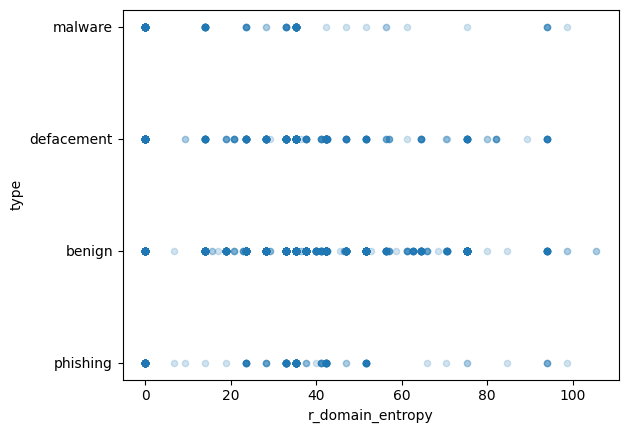

In [41]:
wdf.plot(x='r_domain_entropy', y='type', kind='scatter', alpha=0.2)

In [42]:
# Determine whether the url has https or not
def isHTTPS(url):
  if "https://" in url:
    return 1
  else:
    return 0

wdf["https"] = wdf['url'].apply(isHTTPS)

wdf["r_https"] = wdf['registrar_url'].apply(isHTTPS)

wdf

,url,type,creation_date,updated_date,expiration_date,domain_name,registrar_url,length,r_length,@,...,r_*,"r_,",r_//,r_(,r_),redirect,domain_entropy,r_domain_entropy,https,r_https
0,br-icloud.com.br,phishing,2024-01-10 00:00:00,2024-12-19 00:00:00,2026-01-10 00:00:00,br-icloud.com.br,,16,0,0,...,0,0,0,0,0,0,52.721829,0.000000,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,2000-02-14 03:25:53,2024-02-14 10:39:41,2026-02-14 03:25:53,MP3RAID.COM,"['http://www.godaddy.com', 'https://www.godadd...",35,53,0,...,0,1,2,0,0,0,36.189475,35.147886,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,2000-01-25 22:48:55,2024-12-01 07:52:25,2028-01-25 22:48:55,bopsecrets.org,http://www.networksolutions.com,31,31,0,...,0,0,1,0,0,0,47.004397,75.207035,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,2025-04-12 00:00:00,NaN,NaN,garage-pirenne.be,,88,0,0,...,0,0,0,0,0,0,82.011734,0.000000,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2024-12-01 17:37:48,2024-12-01 17:43:54,2025-12-01 17:37:48,ADVENTURE-NICARAGUA.NET,http://www.above.com,235,20,0,...,0,0,1,0,0,0,111.301639,23.502199,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,movies.tvguide.com/eastern-promises/285629,benign,1994-12-06 05:00:00,2024-03-15 14:49:36,2026-12-05 05:00:00,TVGUIDE.COM,http://www.tucows.com,42,21,0,...,0,0,1,0,0,0,32.903078,28.202638,0,0
9996,http://themeforest.net/item/moksha-one-multi-p...,benign,2007-11-27 03:49:29,2023-10-26 09:43:29,2025-11-27 03:49:29,THEMEFOREST.NET,http://www.markmonitor.com,101,26,0,...,0,0,1,0,0,0,51.704837,51.704837,0,0
9997,flaggedrevs.labs.wikimedia.org/wiki/New_York_S...,benign,2003-03-16 08:22:47,2025-02-17 09:23:41,2026-03-16 08:22:47,wikimedia.org,http://www.markmonitor.com,59,26,0,...,0,0,1,0,0,0,42.303957,51.704837,0,0
9998,thetakeaway.org/people/victor-begg/,benign,2008-01-26 03:23:04,2024-12-27 22:29:33,2026-01-26 03:23:04,thetakeaway.org,"['http://registrar.amazon.com', 'https://regis...",35,63,0,...,0,1,2,0,0,0,51.704837,35.147886,0,1


### Date handling

In [43]:
import pytz

def get_age_days(date):
    if pd.isna(date):
        return -1
    
    date = date[:19]

    url_date = pd.to_datetime(date)
    today = pd.Timestamp.today()

    return (today - url_date).days


wdf['creation_date'] = wdf['creation_date'].apply(get_age_days)
wdf['expiration_date'] = wdf['expiration_date'].apply(get_age_days)
wdf['updated_date'] = wdf['updated_date'].apply(get_age_days)

wdf



,url,type,creation_date,updated_date,expiration_date,domain_name,registrar_url,length,r_length,@,...,r_*,"r_,",r_//,r_(,r_),redirect,domain_entropy,r_domain_entropy,https,r_https
0,br-icloud.com.br,phishing,498,154,-233,br-icloud.com.br,,16,0,0,...,0,0,0,0,0,0,52.721829,0.000000,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,9229,463,-268,MP3RAID.COM,"['http://www.godaddy.com', 'https://www.godadd...",35,53,0,...,0,1,2,0,0,0,36.189475,35.147886,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,9248,172,-979,bopsecrets.org,http://www.networksolutions.com,31,31,0,...,0,0,1,0,0,0,47.004397,75.207035,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,40,-1,-1,garage-pirenne.be,,88,0,0,...,0,0,0,0,0,0,82.011734,0.000000,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,171,171,-194,ADVENTURE-NICARAGUA.NET,http://www.above.com,235,20,0,...,0,0,1,0,0,0,111.301639,23.502199,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,movies.tvguide.com/eastern-promises/285629,benign,11125,432,-562,TVGUIDE.COM,http://www.tucows.com,42,21,0,...,0,0,1,0,0,0,32.903078,28.202638,0,0
9996,http://themeforest.net/item/moksha-one-multi-p...,benign,6386,574,-189,THEMEFOREST.NET,http://www.markmonitor.com,101,26,0,...,0,0,1,0,0,0,51.704837,51.704837,0,0
9997,flaggedrevs.labs.wikimedia.org/wiki/New_York_S...,benign,8103,94,-298,wikimedia.org,http://www.markmonitor.com,59,26,0,...,0,0,1,0,0,0,42.303957,51.704837,0,0
9998,thetakeaway.org/people/victor-begg/,benign,6326,145,-249,thetakeaway.org,"['http://registrar.amazon.com', 'https://regis...",35,63,0,...,0,1,2,0,0,0,51.704837,35.147886,0,1


### Registrar Count

In [44]:
wdf['r_count'] = wdf['registrar_url'].apply(lambda x: x.count(',') + 1)

# Model Preperation

In [45]:
ord_map= {
    'malware' : 0,
    'benign': 1,
    'phishing': 2,
    'defacement': 3,
}
X = wdf.drop(['url', 'type', 'domain_name', 'registrar_url'], axis=1)
y = wdf['type'].map(ord_map)

Split data into train and test

In [46]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=0)

# MLP Classifier

In [47]:
model = MLPClassifier(hidden_layer_sizes=(4, 16, 4),
                      solver='adam',
                      learning_rate_init=0.001,
                      activation='relu',
                      batch_size=64,
                      max_iter=500,
                      early_stopping=True,
                      validation_fraction=0.1,
                      verbose=True)

model.fit(Xtrain, ytrain)

Iteration 1, loss = 4.91326535
Validation score: 0.116358
Iteration 2, loss = 1.75929849
Validation score: 0.134907
Iteration 3, loss = 1.52637321
Validation score: 0.136594
Iteration 4, loss = 1.41875360
Validation score: 0.136594
Iteration 5, loss = 1.32372152
Validation score: 0.138280
Iteration 6, loss = 1.23793683
Validation score: 0.802698
Iteration 7, loss = 1.16099816
Validation score: 0.802698
Iteration 8, loss = 1.09451936
Validation score: 0.802698
Iteration 9, loss = 1.03663831
Validation score: 0.802698
Iteration 10, loss = 0.98568907
Validation score: 0.802698
Iteration 11, loss = 0.94078178
Validation score: 0.802698
Iteration 12, loss = 0.90169355
Validation score: 0.802698
Iteration 13, loss = 0.86784927
Validation score: 0.802698
Iteration 14, loss = 0.83861832
Validation score: 0.802698
Iteration 15, loss = 0.81336190
Validation score: 0.802698
Iteration 16, loss = 0.79177097
Validation score: 0.802698
Iteration 17, loss = 0.77317019
Validation score: 0.802698
Valida

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=(4, 16, 4),
              max_iter=500, verbose=True)

In [48]:
for i, layer in enumerate(model.coefs_):
  print('Layer', i, 'has', layer.shape[0], 'nodes, each with', layer.shape[1], 'weight(s)')

Layer 0 has 41 nodes, each with 4 weight(s)
Layer 1 has 4 nodes, each with 16 weight(s)
Layer 2 has 16 nodes, each with 4 weight(s)
Layer 3 has 4 nodes, each with 4 weight(s)


In [49]:
model.best_validation_score_

0.8026981450252951

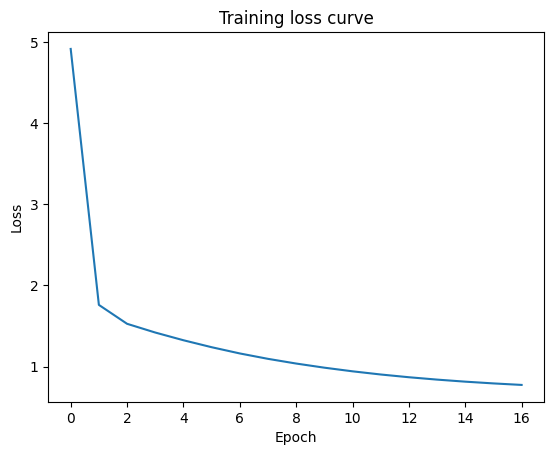

In [50]:
plt.plot(model.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training loss curve')
plt.show()

In [51]:
ypred = model.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.80      1.00      0.89      2037
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       371

    accuracy                           0.80      2538
   macro avg       0.20      0.25      0.22      2538
weighted avg       0.64      0.80      0.71      2538



c:\Users\smitty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\smitty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\smitty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# Random Forest Classifier

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.39      0.56        44
           1       0.93      0.99      0.96      1378
           2       1.00      0.05      0.09        43
           3       0.86      0.78      0.82       227

    accuracy                           0.92      1692
   macro avg       0.95      0.55      0.60      1692
weighted avg       0.92      0.92      0.91      1692



# PCA

original shape:    (8459, 41)
transformed shape: (8459, 2)


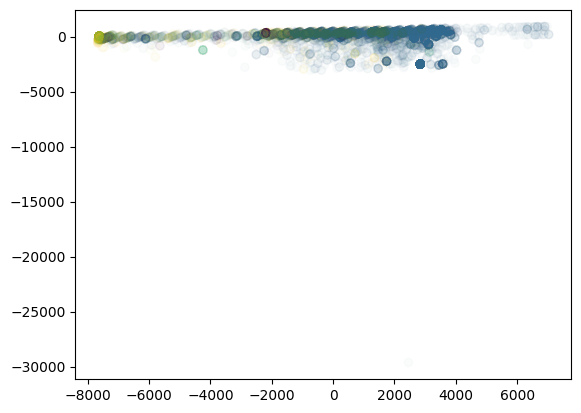

In [53]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)


fig, ax = plt.subplots()

# note that transformed data becomes a numpy array
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.02)

# XGBoost Classifier

In [54]:
model = XGBClassifier(n_estimators=1, max_depth=300, learning_rate=0.001)

model.fit(Xtrain, ytrain)

# make predictions for test data
ypred = model.predict(Xtest)

# evaluate predictions
accuracy = accuracy_score(ytest, ypred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 96.02%


In [55]:
param_grid = {'n_estimators': np.arange(10, 18, 1),
              'max_depth': np.arange(12, 22, 2),
              'learning_rate': np.arange(0.1, 0.17, 0.01)}

# We can incorporate cross-validation into the grid search
# by specifying cv=5.
grid = GridSearchCV(XGBClassifier(), param_grid, cv=3, verbose=1)

# We'll use just the training data, so that we can evaluate the best
# model against data that was unseen during training.
grid.fit(Xtrain, ytrain)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17]),
                         'max_depth': array([12, 14, 16, 18, 20]),
                         'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17])},
             verbose=1)

In [56]:
print(grid.best_params_)

# and the best accuracy
print(grid.best_score_)

# then we can train the final model with the best hyperparameters
# model = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=0.1)
# model.fit(Xtrain, ytrain)

# predict the test data to see how well the model generalizes
ypred = model.predict(Xtest)
accuracy = accuracy_score(ytest, ypred)
print(accuracy)

{'learning_rate': np.float64(0.15999999999999998), 'max_depth': np.int64(16), 'n_estimators': np.int64(14)}
0.9668975101732217
0.9602048857368006


In [57]:
model = XGBClassifier(n_estimators=15, max_depth=18, learning_rate=0.13)

model.fit(Xtrain, ytrain)

# make predictions for test data
ypred = model.predict(Xtest)

# evaluate predictions
accuracy = accuracy_score(ytest, ypred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 96.38%


Text(0.5, 1.0, 'Feature Importance in Malicious Urls')

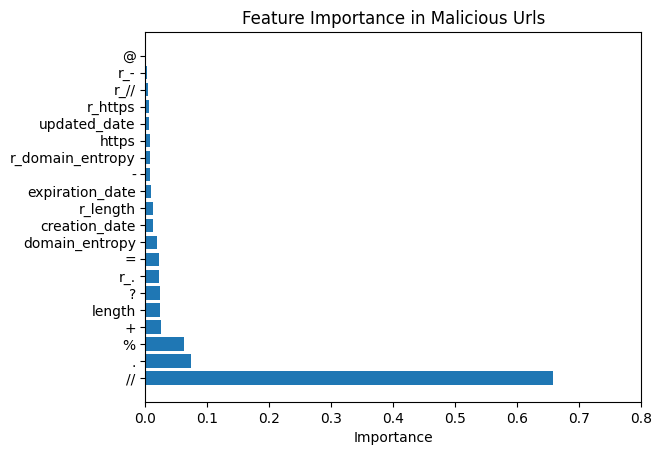

In [58]:
# Feature Importance
# Make a DataFrame for ease of sorting and visualization
feat_imp = pd.DataFrame({'Feature': X.columns,
                      'Importance': model.feature_importances_})

feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

feat_imp = feat_imp[:20]

fig, ax = plt.subplots()

# horizontal bar charts can make text easier to read
ax.barh(feat_imp['Feature'], feat_imp['Importance'])
ax.set_xlabel('Importance')
ax.set_xlim(0, 0.8)
ax.set_title('Feature Importance in Malicious Urls')

# Prediction Matrix

[[  43    4    3    6]
 [   2 2021   11    3]
 [   2   29   28   15]
 [   3   14    0  354]]
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        56
           1       0.98      0.99      0.98      2037
           2       0.67      0.38      0.48        74
           3       0.94      0.95      0.95       371

    accuracy                           0.96      2538
   macro avg       0.86      0.77      0.81      2538
weighted avg       0.96      0.96      0.96      2538



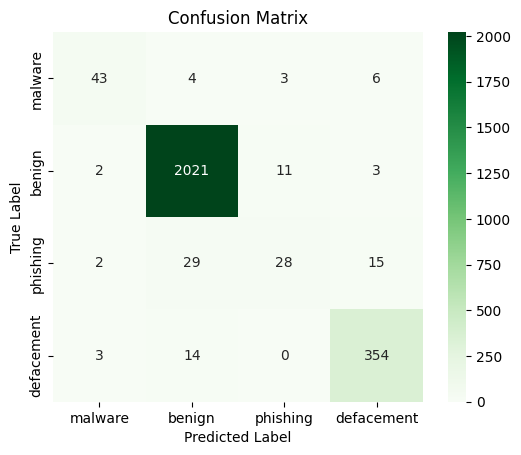

In [ ]:
print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))
# label_map = {
#     1: 'malware',
#     0: 'benign',
#     # 2: 'phishing',
#     # 3: 'defacement',
# }
# labels = [0,1]
label_map = {
    0: 'malware',
    1: 'benign',
    2: 'phishing',
    3: 'defacement',
}
labels = [0,1,2,3]
cm = confusion_matrix(ytest, ypred, labels=labels)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                    cmap="Greens",
                    xticklabels=list(label_map.values()),
                    yticklabels=list(label_map.values()))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()